### Comparative Analysis of Binary Classification Supervised Learning Methods: Naive Bayes, SVM, and CNN for Weed Detection in Soybean Crops

### Introductionn

Weed image classification is an important task in precision agriculture, which aims to improve farming practices by using advanced technologies and data-driven decision-making. The main objective of weed image classification is to distinguish between weed and crop plants in images taken from agricultural fields. By accurately identifying weed species and their locations, farmers can take targeted actions to control weed growth, leading to improved crop yields and reduced usage of herbicides.

I chose the dataset "Weed Detection in Soybean Crops" from Kaggle (https://www.kaggle.com/datasets/fpeccia/weed-detection-in-soybean-crops).
About the dataset used in this project, it is picked from the original dataset by 260 and 5000 for weed and non weed images, respectively.

It is a dataset with labels, so I determine to use supervise learning methods to complete the task of binary weed classification. Let's start from naive bayes and suppoert vector machine, which are we learned from the class. 

If you want to redo theis notebook, please download the dataset from the link (https://iastate.box.com/s/vg4j359vhbo5ad8orkcc7aqxbibkmyvq).

#### Pre-preparation

In [137]:
import numpy as np
import cv2
import os
import glob
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader

In [146]:
class WeedDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        img = torch.from_numpy(img).unsqueeze(0).float() / 255.0
        label = self.labels[index]
        return img, label

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def cnn(X_train, X_test, y_train, y_test, optm="SGD"):
    train_dataset = WeedDataset(X_train, y_train)
    test_dataset = WeedDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = BinaryClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 30
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float).view(-1, 1)
            
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc_cnn = correct / total
    
    torch.save(model.state_dict(), f'weights_{num_epochs}.pth')

    return acc_cnn, elapsed_time

In [110]:
def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(os.path.join(path, "*.tif")):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        images.append(img)
        labels.append(label)
    return images, labels

def run(method, sampling=0, crossvalidation=0, optm="SGD"):

    weed_images, weed_labels = load_images("weed", 1)
    non_weed_images, non_weed_labels = load_images("non_weed", 0)
    all_images = np.array(weed_images + non_weed_images)
    all_labels = np.array(weed_labels + non_weed_labels)

    X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

    if method == "nb":
        start_time = time.time()
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        if sampling != 0:
            resampling = Pipeline([('oversample', SMOTE()), ('undersample', RandomUnderSampler())])
            X_train, y_train = resampling.fit_resample(X_train, y_train)
        mtd = GaussianNB()
        mtd.fit(X_train, y_train)
        y_pred = mtd.predict(X_test)
        end_time = time.time()
        elapsed_time = end_time - start_time
        acc = accuracy_score(y_test, y_pred)

    elif method == "svm":
        start_time = time.time()
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if crossvalidation != 0:
            param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}
            mtd = GridSearchCV(SVC(), param_grid, cv=2, verbose=2)
            mtd.fit(X_train_scaled, y_train)
            best_svm = mtd.best_estimator_
            y_pred = best_svm.predict(X_test_scaled)
        else:
            mtd = SVC(kernel='linear', C=1, gamma=0.1)
            mtd.fit(X_train_scaled, y_train)
            y_pred = mtd.predict(X_test_scaled)
            
        acc = accuracy_score(y_test, y_pred)
        end_time = time.time()
        elapsed_time = end_time - start_time
    
    elif method == "cnn":
        acc, elapsed_time = cnn(X_train, X_test, y_train, y_test, optm)
    
    return acc, elapsed_time

### Naive Bayes

In [6]:
acc_nb, elapsed_time_nb = run("nb")

The ratio of non weed and weed is 5000/260, which is greater than 19, and thus it could be considered as an imbalanced dataset. Here, oversampling and undersampling was applied to deal with this issue.

### Naive Bayes with oversampling and undersampling

In [9]:
acc_nb_os, elapsed_time_nb_os = run("nb", sampling=1)

### Support Vector Machine

In [11]:
acc_svm, elapsed_time_svm = run("svm")

There are lots of hyperparameters, like C, gamma and kernel, could be tuned. Now, the cross-validation was implemented in SVM to improve the accuracy.

### Support Vector Machine with cross-validation

In [92]:
acc_svm_cv, elapsed_time_svm_cv = run("svm", crossvalidation=1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.2s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.2s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   2.1s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   2.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   9.2s
[CV] END ......................C=0.1, gamma=0.01

In my research, I usually use SGD to solve the problem. In this part, I would like to use this method.

### Convolution Neuronal Network with gradient descent

In [149]:
acc_cnn, elapsed_time_cnn = run("cnn")

### Visualize the results

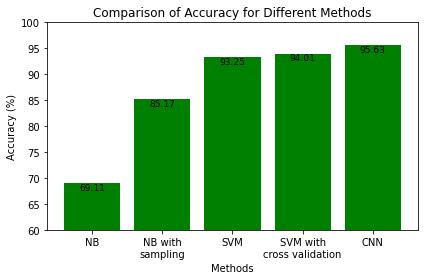

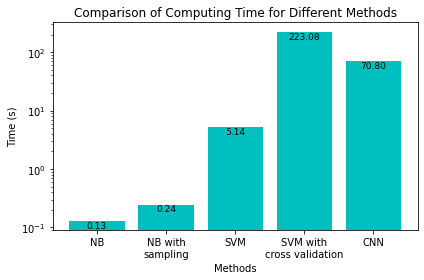

In [150]:
import matplotlib.pyplot as plt

methods = ['NB', 'NB with\nsampling', 'SVM', 'SVM with\ncross validation', 'CNN']
accuracies = np.array([acc_nb, acc_nb_os, acc_svm, acc_svm_cv, acc_cnn]) *100
times = np.array([elapsed_time_nb, elapsed_time_nb_os, elapsed_time_svm, elapsed_time_svm_cv, elapsed_time_cnn])

def add_value_labels(bs):
    for bar in bs:
        height = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2,height,f'{height:.2f}',ha='center',va='top',fontsize=9)

bar_acc = plt.bar(methods, accuracies, color='g')
plt.yscale('linear')
plt.ylim([60,100])
plt.xlabel('Methods')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Accuracy for Different Methods')
add_value_labels(bar_acc)
plt.tight_layout()
plt.savefig('acc.png', dpi=300)
plt.show()

bar_time = plt.bar(methods, times, color='c')
plt.yscale('log')
plt.xlabel('Methods')
plt.ylabel('Time (s)')
plt.title('Comparison of Computing Time for Different Methods')
add_value_labels(bar_time)
plt.tight_layout()
plt.savefig('time.png', dpi=300)
plt.show()